In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.utils import resample
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# import the data and  drop no longer needed columns 
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Education,cat_Entertainment,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_Other,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology
0,0,0,6,11,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,20,4,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,18,3,10,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,19,0,11,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,20,2,10,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [3]:
# split into features and target variable
X = video_df.drop(columns="box_view_rate")
y = video_df["box_view_rate"]

# split into training and test data
SEED = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Education,cat_Entertainment,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_Other,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology
50,0,11,0,11,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
397,0,1,5,9,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
349,0,1,0,10,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
346,0,16,3,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
759,0,4,2,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# hyperparameter tune a decision tree regressor
params = {"decisiontreeregressor__max_depth": [3, 5, 10, 15, 20, 30, None], "decisiontreeregressor__min_samples_leaf": [2, 4, 6], "decisiontreeregressor__min_samples_split": [2, 5, 10]}
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.6255478249759243, best params: {'decisiontreeregressor__max_depth': 3, 'decisiontreeregressor__min_samples_leaf': 6, 'decisiontreeregressor__min_samples_split': 2}


In [6]:
# fit decision tree with optimal parameters
dt = DecisionTreeRegressor(max_depth=best_params["decisiontreeregressor__max_depth"], min_samples_leaf=best_params["decisiontreeregressor__min_samples_leaf"], min_samples_split=best_params["decisiontreeregressor__min_samples_split"], random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = dt.score(X_test, y_test)
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.6225342614158438, rmse: 1.9880967988272114


In [7]:
# instantiate random forest and use randomized cross validation to search wide range of hyperparameters
params = {"randomforestregressor__n_estimators": [100, 200, 300, 500, 1000], "randomforestregressor__max_depth": [10, 20, 30, 50, None], "randomforestregressor__min_samples_leaf": [2, 4, 6],
          "randomforestregressor__max_features": ["sqrt", "log2", None], "randomforestregressor__bootstrap": [True, False]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
rand_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1, random_state=SEED)
rand_search.fit(X_train, y_train)
best_params = rand_search.best_params_
print(f"best score: {rand_search.best_score_}, best params: {best_params}")

best score: 0.7357524402815965, best params: {'randomforestregressor__n_estimators': 500, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': None, 'randomforestregressor__bootstrap': True}


In [8]:
# use gridsearch for fine-tuning hyperparameters
params = {"randomforestregressor__n_estimators": np.arange(best_params["randomforestregressor__n_estimators"] - 20, best_params["randomforestregressor__n_estimators"] + 30, 10), "randomforestregressor__max_depth": [best_params["randomforestregressor__max_depth"]],
          "randomforestregressor__min_samples_leaf": [best_params["randomforestregressor__min_samples_leaf"]], "randomforestregressor__max_features": [best_params["randomforestregressor__max_features"]],
          "randomforestregressor__bootstrap": [best_params["randomforestregressor__bootstrap"]]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.7358627438201838, best params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': np.int64(490)}


In [9]:
# fit random forest with optimal parameters
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=best_params["randomforestregressor__n_estimators"], max_depth=best_params["randomforestregressor__max_depth"], min_samples_leaf=best_params["randomforestregressor__min_samples_leaf"],
                           max_features=best_params["randomforestregressor__max_features"], bootstrap=best_params["randomforestregressor__bootstrap"], random_state=SEED))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = pipeline.score(X_test, y_test)
rf = pipeline.named_steps["randomforestregressor"]
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.7865089843467198, rmse: 1.4951630597361332


In [10]:
# calculate 95% confidence intervals
r2_scores = []
rmse_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = pipeline.predict(X_resampled)
    rmse = root_mean_squared_error(y_resampled, y_resampled_pred)
    r2 = pipeline.score(X_resampled, y_resampled)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

r2_lower = np.percentile(r2_scores, 2.5)
r2_upper = np.percentile(r2_scores, 97.5)
rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
print(f"R2 CI: [{r2_lower}, {r2_upper}], RMSE CI: [{rmse_lower}, {rmse_upper}]")

R2 CI: [0.7579911061123958, 0.8111567171000047], RMSE CI: [1.4068920772817848, 1.588633010400205]


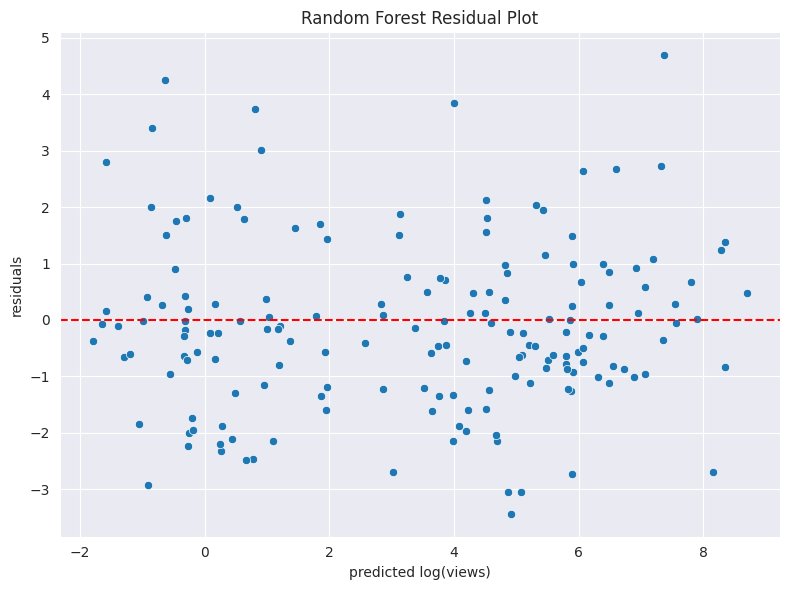

In [11]:
# visualize residuals to look for patterns
residuals = y_test - y_pred
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted log(views)")
plt.ylabel("residuals")
plt.title("Random Forest Residual Plot")
plt.tight_layout()

# save png
plt.savefig("images/rf_residual_plot.png", dpi=300)
plt.show()

In [12]:
# list top model feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)
top_features

log_channel_sub_count           0.619196
cbrt_published_duration_days    0.102768
log_channel_view_count          0.028548
log_channel_video_count         0.026688
log_duration_seconds            0.018944
term_gains                      0.011114
term_vegan                      0.008226
title_length                    0.007963
cbrt_description_length         0.007881
term_outreach                   0.007596
term_animal                     0.007027
hour_published                  0.006039
term_music                      0.005027
tag_count                       0.004715
term_eat                        0.004563
term_instagram                  0.004518
term_https                      0.004119
month_published                 0.004009
weekday_published               0.004006
term_com                        0.003744
dtype: float64

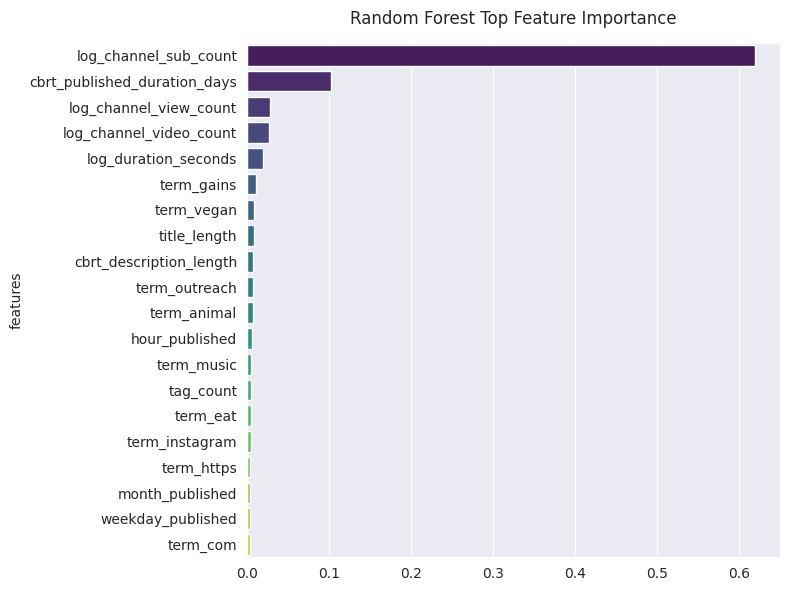

In [13]:
# visualize top 10 important features
plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("Random Forest Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/rf_top_feature_importance.png", dpi=300)
plt.show()

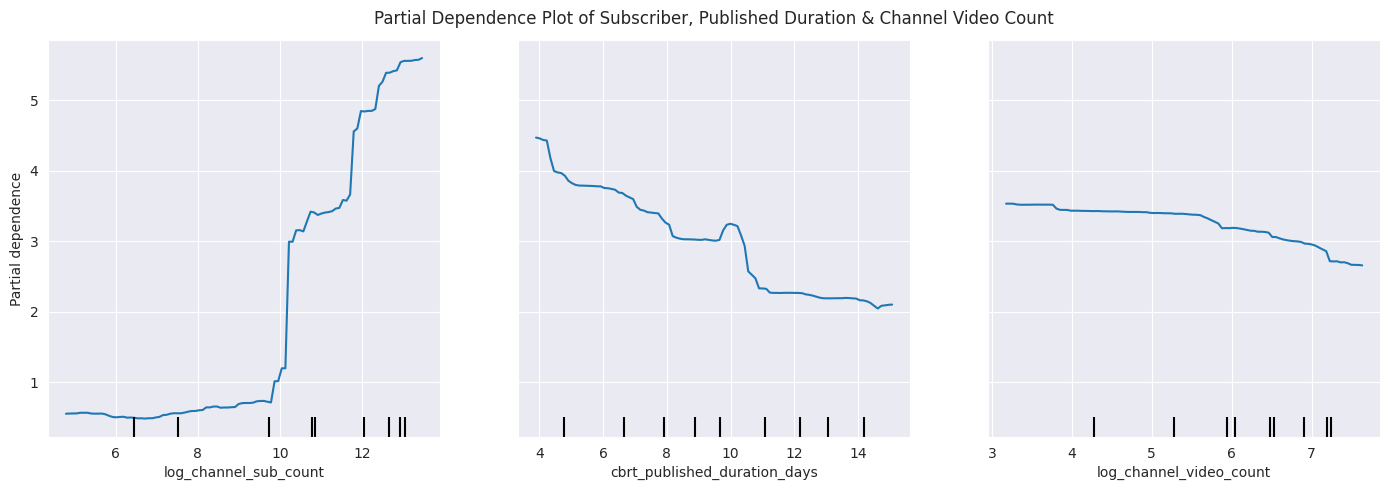

In [14]:
# visualize partial dependence for subscribers, video count & channel view count
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_channel_sub_count", "cbrt_published_duration_days", "log_channel_video_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Subscriber, Published Duration & Channel Video Count", y=1.02)
plt.tight_layout()

# save png
# plt.savefig("images/pdp_sub_video_channel_view_count.png", dpi=300)
plt.show()

/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


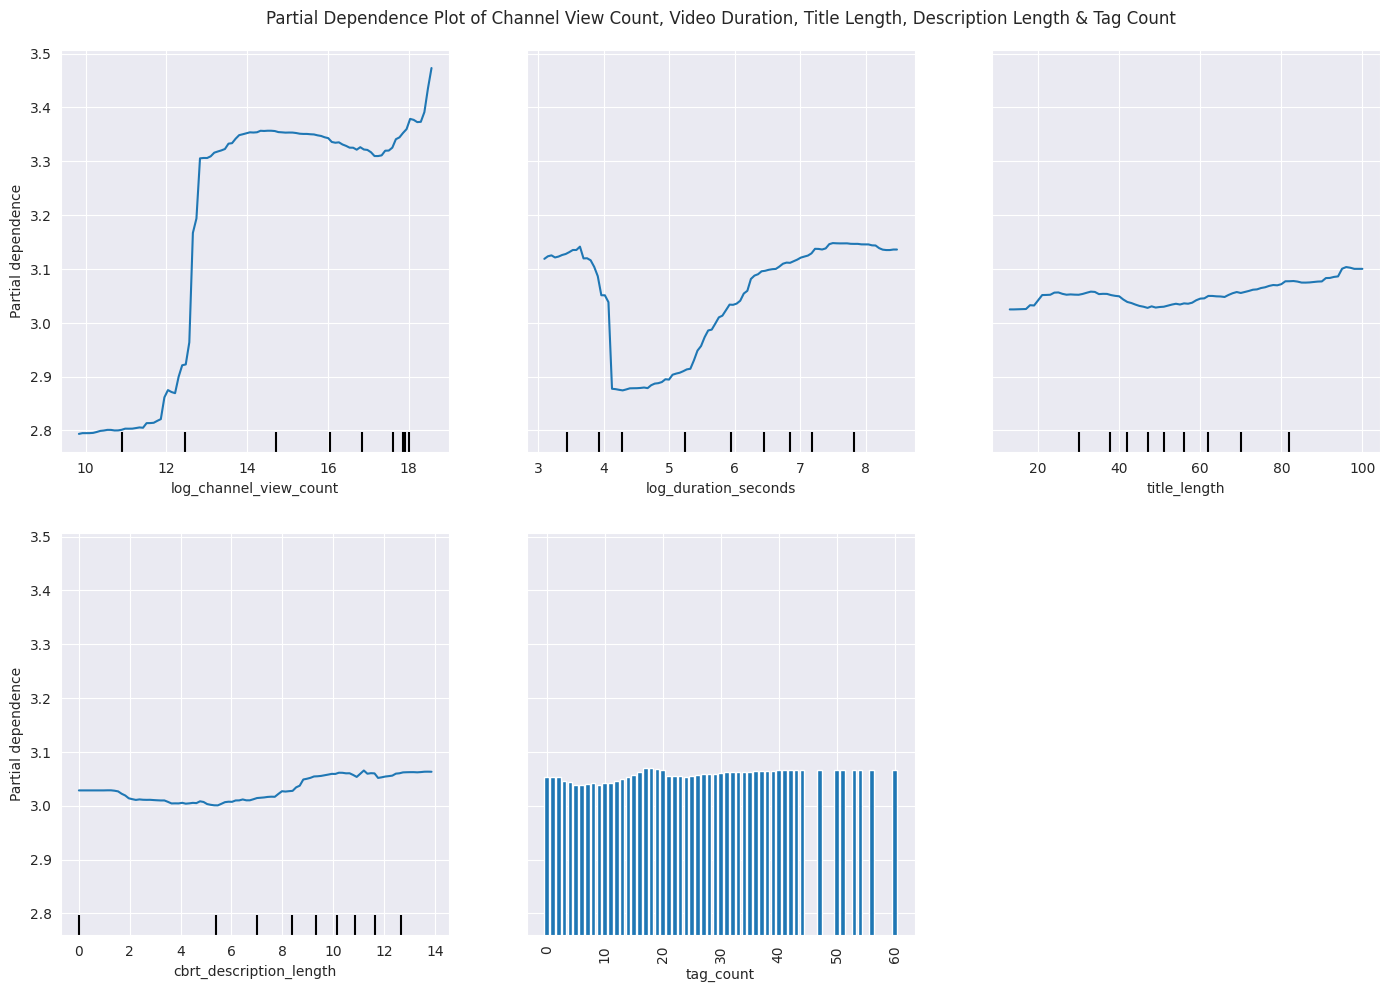

In [15]:
# visualize partial dependence for duration, description length & tag count
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_channel_view_count", "log_duration_seconds", "title_length", "cbrt_description_length", "tag_count"], categorical_features=["tag_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Channel View Count, Video Duration, Title Length, Description Length & Tag Count", y=1.02)
plt.tight_layout()

# save fig
# plt.savefig("images/pdp_duration_desc_length_tag_count.png", dpi=300)
plt.show()

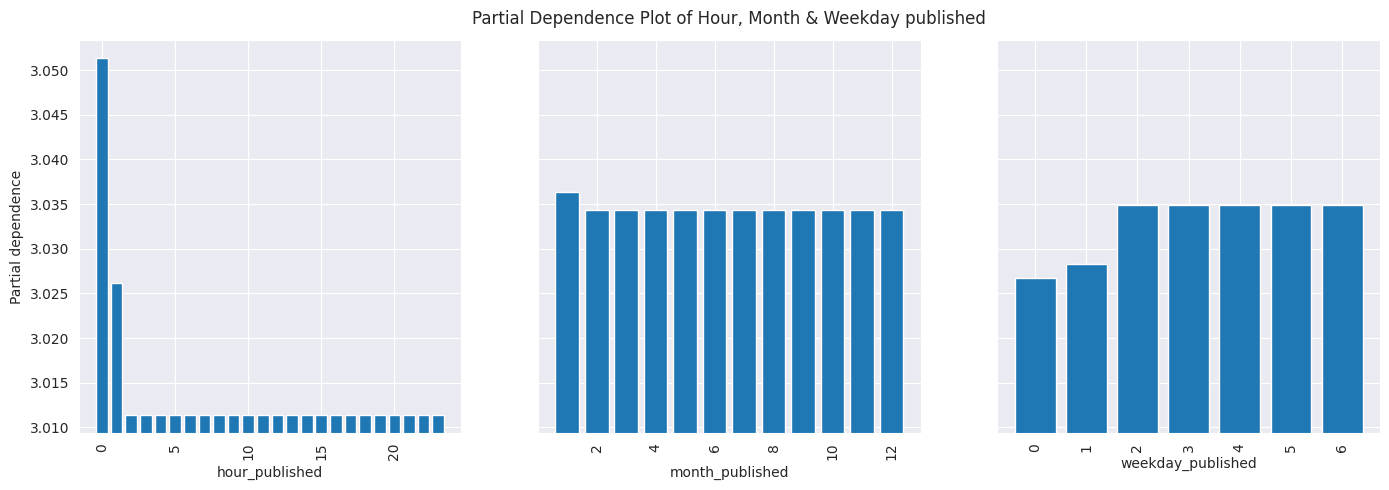

In [16]:
# visualize partial dependence for hour, month & weekday published
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=rf, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Hour, Month & Weekday published", y=1.02)
plt.tight_layout()

# save png
# plt.savefig("images/pdp_hour_month_weekday_pub.png", dpi=300)
plt.show()

In [17]:
# get the shap values of each feature
scaler = pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
explainer = shap.TreeExplainer(rf)
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()


,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Education,cat_Entertainment,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_Other,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology
0,-0.004148,0.026130,0.010184,0.008901,0.000956,0.025247,0.004625,-0.004807,0.000756,-0.000164,...,-0.002670,0.000993,-0.000595,-0.000327,0.000908,0.008551,-0.000167,0.014630,0.001703,2.594617e-07
1,-0.007120,-0.138880,-0.007104,-0.001937,-0.002186,0.003920,-0.000181,-0.000750,-0.001727,-0.000083,...,-0.001849,0.000125,-0.000374,-0.000157,0.000396,0.004424,0.007989,-0.005112,0.001391,1.447654e-05
2,-0.008462,-0.011967,0.014976,0.004356,0.001279,-0.055749,-0.006819,-0.006375,0.000721,-0.000194,...,-0.002481,0.000742,-0.000385,-0.000355,0.000723,-0.011693,-0.000230,-0.001243,0.002142,1.673684e-05
3,-0.003137,-0.007513,-0.026588,-0.030955,-0.004725,0.006345,-0.004388,-0.000234,-0.002684,-0.000015,...,-0.002718,0.000718,-0.000701,-0.000120,0.000150,0.004533,-0.000279,0.005430,0.002059,2.620931e-05
4,-0.024080,0.008488,0.004124,0.000297,0.000849,0.004835,-0.000309,0.002067,0.000346,0.000292,...,-0.002515,0.000476,-0.000586,-0.000110,0.000153,0.004321,-0.000849,0.001021,0.000586,9.507005e-05


In [18]:
# list the top term features
terms = []
for col in feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]
top_terms

['term_gains',
 'term_vegan',
 'term_outreach',
 'term_animal',
 'term_music',
 'term_eat',
 'term_instagram',
 'term_https',
 'term_com',
 'term_learn',
 'term_subscribe',
 'term_www',
 'term_truth',
 'term_animals',
 'term_rights',
 'term_video',
 'term_youtu',
 'term_support',
 'term_org',
 'term_youtube']

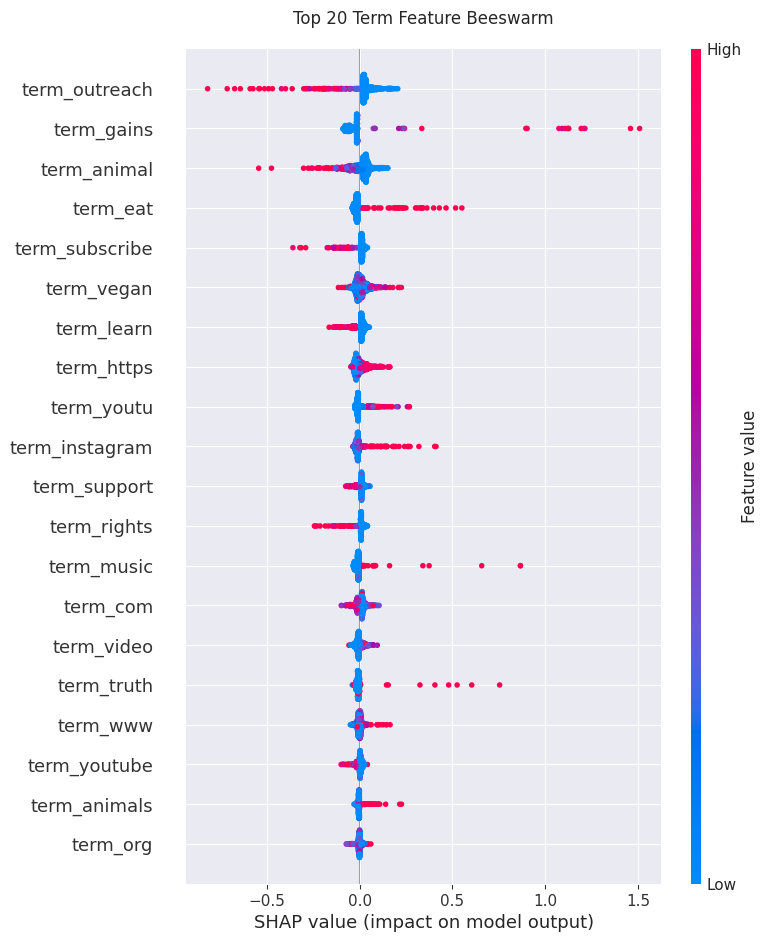

In [19]:
# visualize beeswarm of top 20 term features
plt.title("Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot", show=False)

# save png
plt.savefig("images/term_beeswarm.png", dpi=300)
plt.show()

In [20]:
# list the category features
categories = []
for col in feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)
categories

['cat_Nonprofits & Activism',
 'cat_Education',
 'cat_People & Blogs',
 'cat_Pets & Animals',
 'cat_Howto & Style',
 'cat_Entertainment',
 'cat_Other',
 'cat_News & Politics',
 'cat_Music',
 'cat_Science & Technology',
 'cat_Comedy']

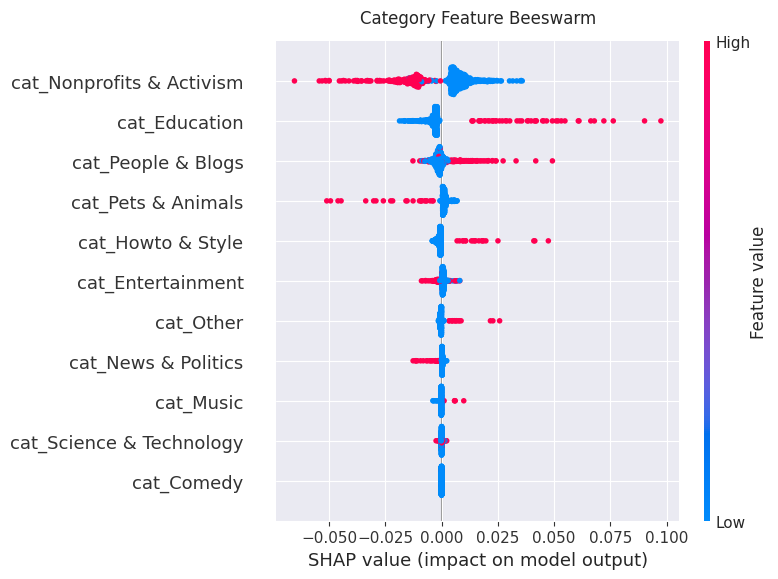

In [21]:
# visualize beeswarm of category features
plt.title("Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot", show=False)
plt.tight_layout()

# save png
plt.savefig("images/category_beeswarm.png", dpi=300)
plt.show()

In [22]:
# save data and random forest model
X_test.to_csv("data/x_test.csv")
residuals.to_csv("data/residuals.csv")
with open("data/pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [23]:
# instantiate xgboost and use randomized cross validation to search wide range of hyperparameters
params = {"xgbregressor__n_estimators": randint(500, 900), "xgbregressor__max_depth": randint(5, 20), "xgbregressor__learning_rate": uniform(0.01, 0.2),
          "xgbregressor__colsample_bytree": uniform(0.5, 0.5), "xgbregressor__gamma": uniform(0, 5), "xgbregressor__reg_alpha": uniform(0, 1), "xgbregressor__reg_lambda": uniform(0, 1)}

xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED))
xgb_rand_search = RandomizedSearchCV(xgb_pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1, random_state=SEED)
xgb_rand_search.fit(X_train, y_train)
xgb_best_params = xgb_rand_search.best_params_
print(f"best score: {xgb_rand_search.best_score_}, best params: {xgb_best_params}")


best score: 0.7561906795025111, best params: {'xgbregressor__colsample_bytree': np.float64(0.6561956461490326), 'xgbregressor__gamma': np.float64(0.6925151296375587), 'xgbregressor__learning_rate': np.float64(0.038594471934687874), 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 757, 'xgbregressor__reg_alpha': np.float64(0.017000008699665115), 'xgbregressor__reg_lambda': np.float64(0.8825344686406884)}


In [24]:
# use gridsearch for fine-tuning hyperparameters
params = {"xgbregressor__n_estimators": np.arange(xgb_best_params["xgbregressor__n_estimators"] - 10, xgb_best_params["xgbregressor__n_estimators"] + 15, 5),
          "xgbregressor__max_depth": np.arange(xgb_best_params["xgbregressor__max_depth"] - 4, xgb_best_params["xgbregressor__max_depth"] + 6, 2),
          "xgbregressor__learning_rate": [xgb_best_params["xgbregressor__learning_rate"]], "xgbregressor__colsample_bytree": [xgb_best_params["xgbregressor__colsample_bytree"]],
          "xgbregressor__gamma": [xgb_best_params["xgbregressor__gamma"]], "xgbregressor__reg_alpha": [xgb_best_params["xgbregressor__reg_alpha"]], "xgbregressor__lambda": [xgb_best_params["xgbregressor__reg_lambda"]]}

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_params = xgb_grid_search.best_params_
print(f"best score: {xgb_grid_search.best_score_}, best params: {xgb_best_params}")

best score: 0.7561906795464136, best params: {'xgbregressor__colsample_bytree': np.float64(0.6561956461490326), 'xgbregressor__gamma': np.float64(0.6925151296375587), 'xgbregressor__lambda': np.float64(0.8825344686406884), 'xgbregressor__learning_rate': np.float64(0.038594471934687874), 'xgbregressor__max_depth': np.int64(5), 'xgbregressor__n_estimators': np.int64(747), 'xgbregressor__reg_alpha': np.float64(0.017000008699665115)}


In [25]:
# fit xgboost with optimal parameters
xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED, n_estimators=xgb_best_params["xgbregressor__n_estimators"],
                                                                max_depth=xgb_best_params["xgbregressor__max_depth"], learning_rate=xgb_best_params["xgbregressor__learning_rate"],
                                                                colsample_bytree=xgb_best_params["xgbregressor__colsample_bytree"], gamma=xgb_best_params["xgbregressor__gamma"],
                                                                reg_alpha=xgb_best_params["xgbregressor__reg_alpha"], reg_lambda=xgb_best_params["xgbregressor__lambda"]))
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = xgb_pipeline.score(X_test, y_test)
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.8187146189052206, rmse: 1.3777808650687102


In [26]:
# calculate 95% confidence intervals
r2_scores = []
rmse_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = xgb_pipeline.predict(X_resampled)
    rmse = root_mean_squared_error(y_resampled, y_resampled_pred)
    r2 = xgb_pipeline.score(X_resampled, y_resampled)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

r2_lower = np.percentile(r2_scores, 2.5)
r2_upper = np.percentile(r2_scores, 97.5)
rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
print(f"R2 CI: [{r2_lower}, {r2_upper}], RMSE CI: [{rmse_lower}, {rmse_upper}]")

R2 CI: [0.792999853124436, 0.842018866454949], RMSE CI: [1.2940458564021524, 1.4684883177604622]


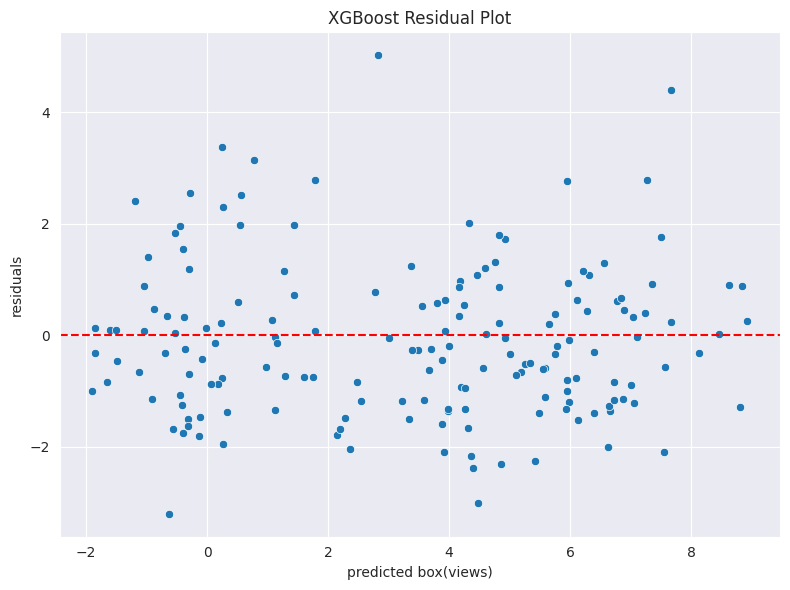

In [27]:
# visualize residuals to look for patterns
residuals = y_test - y_pred
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted box(views)")
plt.ylabel("residuals")
plt.title("XGBoost Residual Plot")
plt.tight_layout()

# save png
# plt.savefig("images/rf_residual_plot.png", dpi=300)

In [28]:
# list top model feature importances
feature_importances = pd.Series(xgb_pipeline["xgbregressor"].feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)
top_features

log_channel_sub_count            0.131345
log_channel_view_count           0.043427
term_ucbhciyivi2szjxjiepn4txg    0.026199
term_raw                         0.025897
term_gains                       0.020458
term_fi                          0.020336
term_learn                       0.018942
term_liberation                  0.015782
cbrt_published_duration_days     0.012534
term_outreach                    0.012283
term_music                       0.012098
term_davidramms                  0.011560
term_subscribe                   0.011451
term_website                     0.011385
tag_meat                         0.011098
cat_Nonprofits & Activism        0.010832
term_vegangains                  0.010427
term_15                          0.009698
term_wayne                       0.009517
term_use                         0.009396
dtype: float32

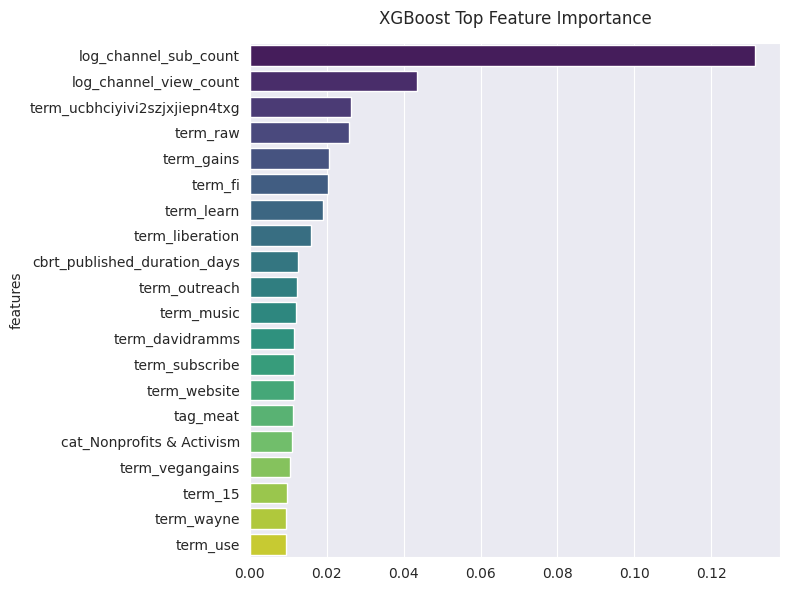

In [29]:
# visualize top 10 important features
plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("XGBoost Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
# plt.savefig("images/rf_top_feature_importance.png", dpi=300)

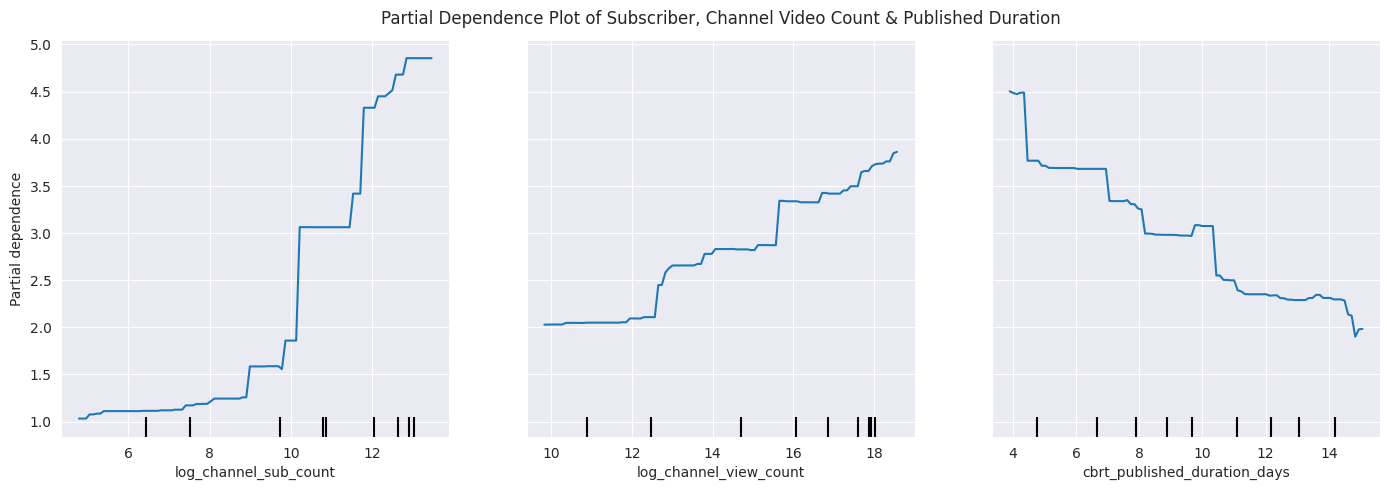

In [30]:
# visualize partial dependence for subscribers, channel view count & published duration
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_view_count", "cbrt_published_duration_days"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Subscriber, Channel Video Count & Published Duration", y=1.02)
plt.tight_layout()

# save png
# plt.savefig("images/pdp_sub_video_channel_view_count.png", dpi=300)

/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


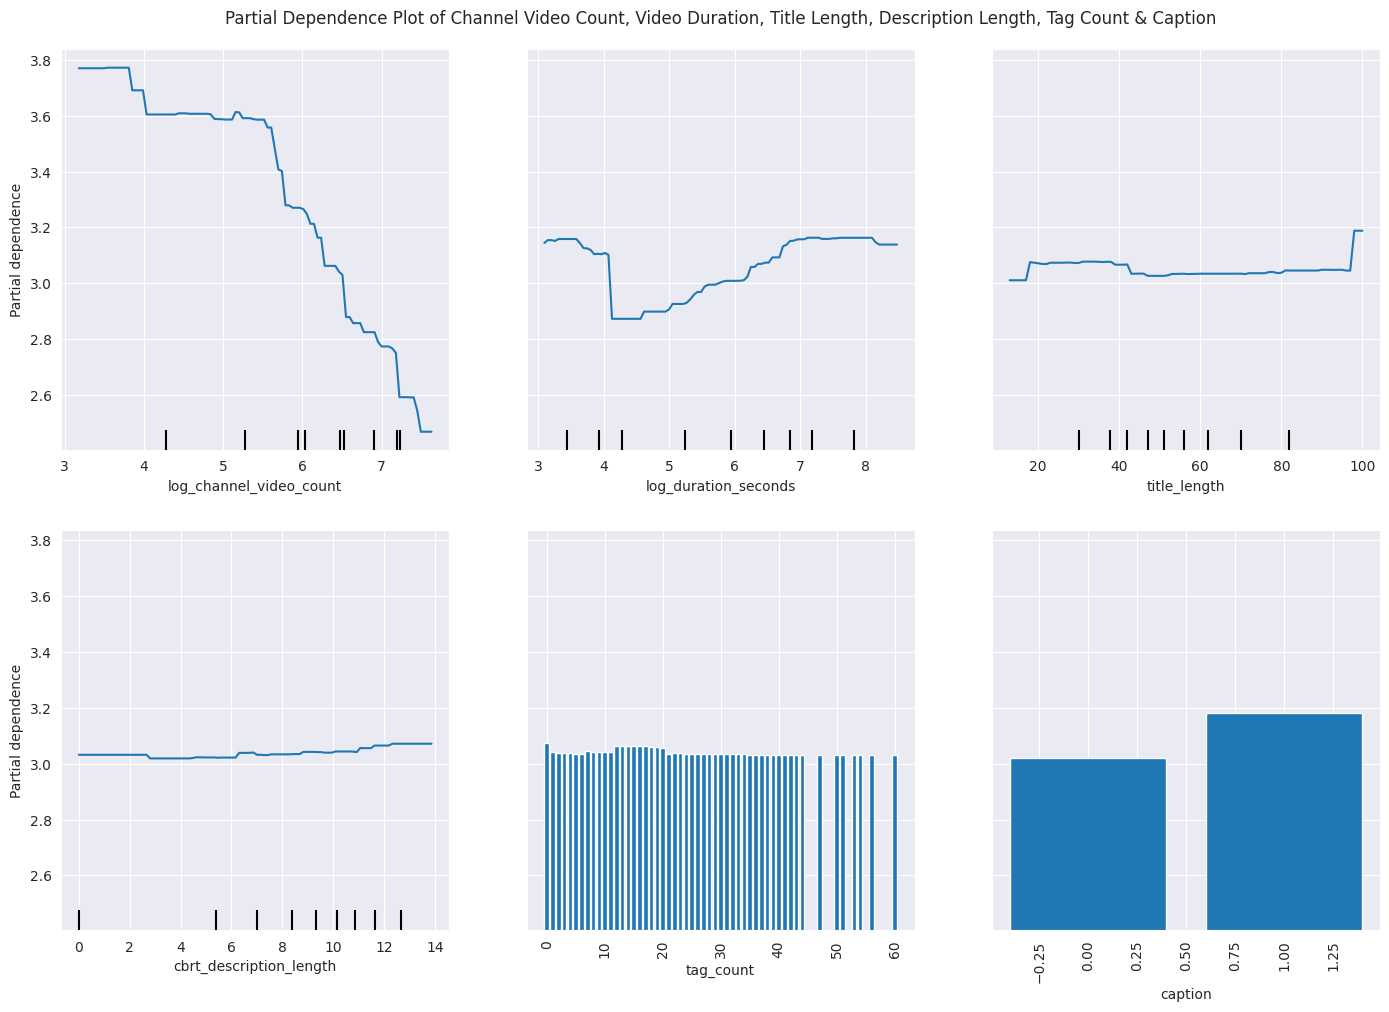

In [31]:
# visualize partial dependence for duration, description length & tag count
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["log_channel_video_count", "log_duration_seconds", "title_length", "cbrt_description_length", "tag_count", "caption"], categorical_features=["tag_count", "caption"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Channel Video Count, Video Duration, Title Length, Description Length, Tag Count & Caption", y=1.02)
plt.tight_layout()

# save fig
# plt.savefig("images/pdp_duration_desc_length_tag_count.png", dpi=300)

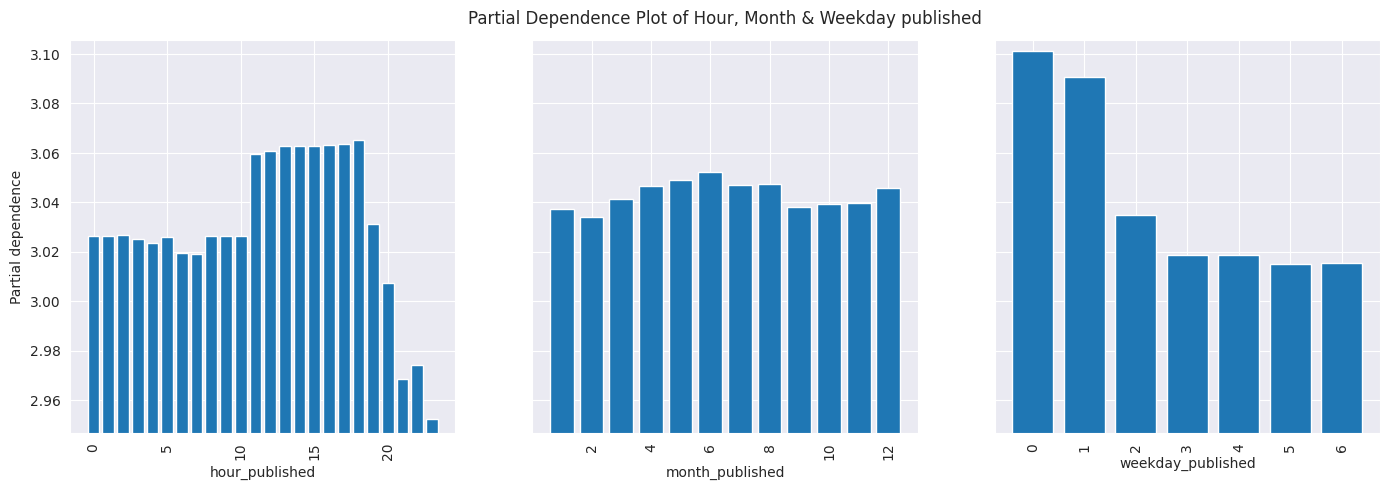

In [32]:
# visualize partial dependence for hour, month & weekday published
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Hour, Month & Weekday published", y=1.02)
plt.tight_layout()

# save png
# plt.savefig("images/pdp_hour_month_weekday_pub.png", dpi=300)

In [33]:
# get the shap values of each feature
scaler = xgb_pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
explainer = shap.TreeExplainer(xgb_pipeline["xgbregressor"])
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Education,cat_Entertainment,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_Other,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology
0,-0.009870,-0.006148,0.056449,0.002196,0.004958,0.001507,0.002355,0.000429,0.001538,-0.000287,...,-0.006736,0.000044,0.0,-0.000353,0.0,0.003662,-0.003771,-0.004935,0.0,0.0
1,-0.029915,-0.009406,-0.031650,-0.005376,-0.032034,0.001473,0.000591,0.001317,0.001556,-0.000287,...,-0.009991,0.000044,0.0,-0.000813,0.0,-0.004470,0.010396,0.000833,0.0,0.0
2,-0.047839,0.040757,0.046508,0.001845,0.007324,-0.055516,-0.000952,0.000757,0.001245,-0.000287,...,-0.009648,0.000044,0.0,-0.001234,0.0,-0.023735,-0.003647,-0.000167,0.0,0.0
3,-0.012534,-0.021366,-0.070369,-0.017728,-0.044427,0.001977,-0.001063,-0.003610,0.002642,-0.000428,...,-0.009304,0.000044,0.0,-0.000297,0.0,0.004367,-0.000321,-0.003949,0.0,0.0
4,-0.037900,-0.010996,-0.004497,-0.002525,0.007920,0.003439,0.000448,0.000235,0.003135,-0.000244,...,-0.006702,0.000044,0.0,-0.001234,0.0,0.002689,-0.000666,-0.022914,0.0,0.0


In [34]:
# list the top term features
terms = []
for col in feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]
top_terms

['term_ucbhciyivi2szjxjiepn4txg',
 'term_raw',
 'term_gains',
 'term_fi',
 'term_learn',
 'term_liberation',
 'term_outreach',
 'term_music',
 'term_davidramms',
 'term_subscribe',
 'term_website',
 'term_vegangains',
 'term_15',
 'term_wayne',
 'term_use',
 'term_org',
 'term_hsiung',
 'term_merch',
 'term_animal',
 'term_anonymous']

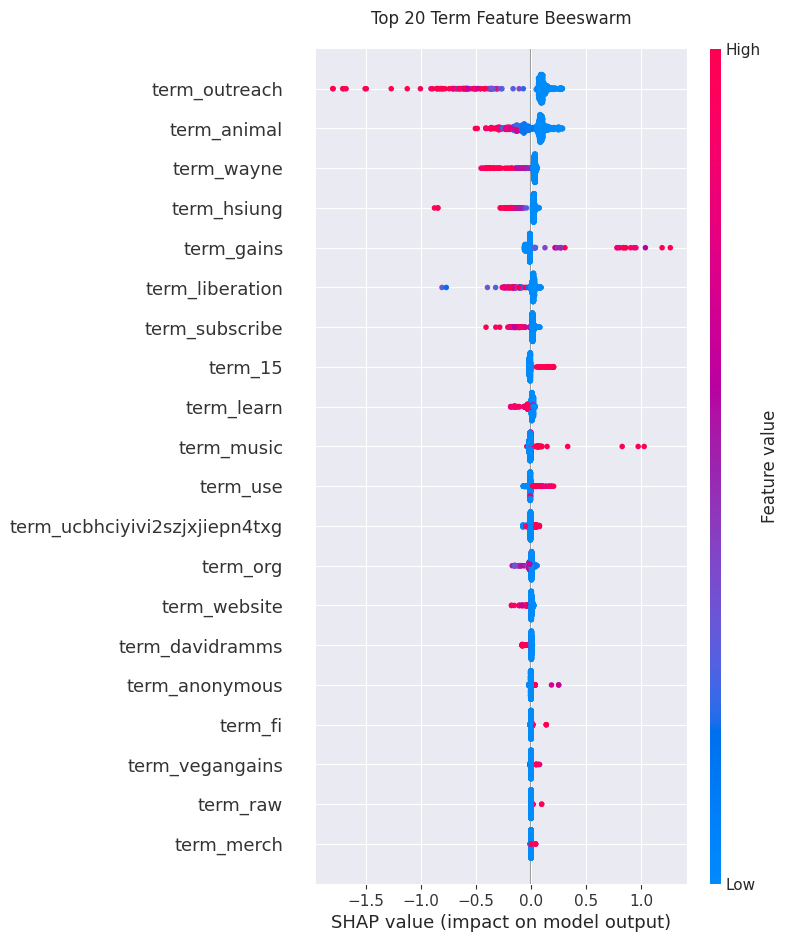

In [35]:
# visualize beeswarm of top 20 term features
plt.title("Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot", show=False)

# save png
# plt.savefig("images/term_beeswarm.png", dpi=300)

In [36]:
# list the category features
categories = []
for col in feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)
categories

['cat_Nonprofits & Activism',
 'cat_People & Blogs',
 'cat_Education',
 'cat_Other',
 'cat_Music',
 'cat_Entertainment',
 'cat_News & Politics',
 'cat_Pets & Animals',
 'cat_Science & Technology',
 'cat_Comedy',
 'cat_Howto & Style']

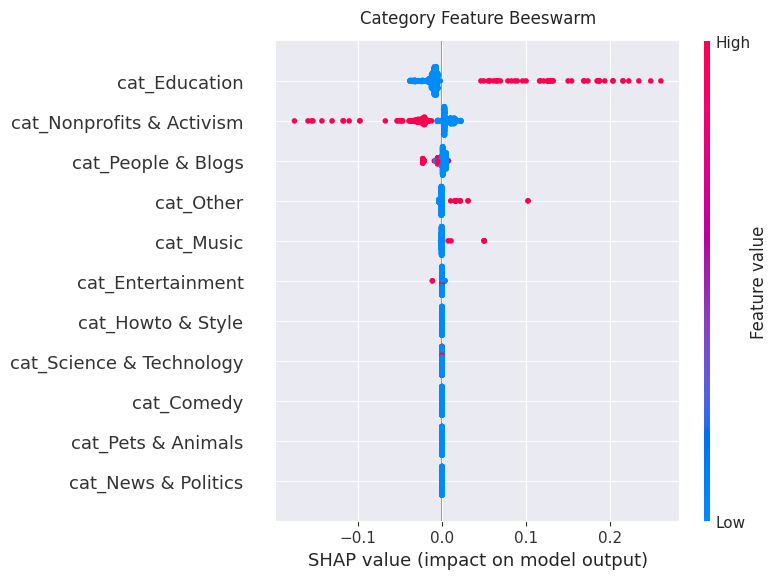

In [37]:
# visualize beeswarm of category features
plt.title("Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot", show=False)
plt.tight_layout()

# save png
# plt.savefig("images/category_beeswarm.png", dpi=300)

In [38]:
# save data and xgboost model
X_test.to_csv("data/x_test.csv")
residuals.to_csv("data/residuals.csv")
with open("data/xgb_pipeline.pkl", "wb") as f:
    pickle.dump(xgb_pipeline, f)